<a href="https://colab.research.google.com/github/suma2011/Training_Lab/blob/main/transformer_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Architecture Demonstration

This notebook provides a comprehensive demonstration of the Transformer architecture, implementing it from scratch with detailed explanations and visualizations.

## Table of Contents
1. **Introduction to Transformers**
2. **Setup and Imports**
3. **Multi-Head Self-Attention Mechanism**
4. **Positional Encoding**
5. **Feed-Forward Networks**
6. **Layer Normalization and Residual Connections**
7. **Complete Transformer Block**
8. **Full Transformer Model**
9. **Training Example**
10. **Attention Visualization**
11. **Conclusion**

## What are Transformers?

Transformers are a neural network architecture introduced in the paper "Attention is All You Need" (Vaswani et al., 2017). They revolutionized natural language processing by:

- **Eliminating recurrence**: Unlike RNNs, transformers process all positions simultaneously
- **Using self-attention**: Each position can attend to all other positions
- **Enabling parallelization**: Much faster training than sequential models
- **Capturing long-range dependencies**: Better at understanding relationships across long sequences


In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from typing import Optional, Tuple

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


Using device: cpu


## 1. Multi-Head Self-Attention Mechanism

The heart of the transformer is the **self-attention mechanism**. It allows each position in the sequence to attend to all other positions, computing attention weights based on similarity.

### Key Concepts:
- **Query (Q)**: What we're looking for
- **Key (K)**: What we're comparing against  
- **Value (V)**: The actual information we want to retrieve
- **Multi-head**: Multiple attention heads capture different types of relationships

### Mathematical Formula:
```
Attention(Q,K,V) = softmax(QK^T / √d_k)V
```

Where d_k is the dimension of the key vectors (for scaling).


In [3]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention mechanism

    This is the core component of transformers that allows the model to attend
    to different parts of the sequence simultaneously using multiple 'heads'.
    """

    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        """
        Args:
            d_model: Model dimension (embedding size)
            num_heads: Number of attention heads
            dropout: Dropout probability
        """
        super(MultiHeadAttention, self).__init__()

        # Ensure d_model is divisible by num_heads
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        # Linear projections for Q, K, V for all heads simultaneously
        self.W_q = nn.Linear(d_model, d_model)  # Query projection
        self.W_k = nn.Linear(d_model, d_model)  # Key projection
        self.W_v = nn.Linear(d_model, d_model)  # Value projection
        self.W_o = nn.Linear(d_model, d_model)  # Output projection

        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor,
                                   mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute scaled dot-product attention

        Args:
            Q: Query tensor [batch_size, num_heads, seq_len, d_k]
            K: Key tensor [batch_size, num_heads, seq_len, d_k]
            V: Value tensor [batch_size, num_heads, seq_len, d_k]
            mask: Optional mask tensor

        Returns:
            attention_output: Weighted values [batch_size, num_heads, seq_len, d_k]
            attention_weights: Attention weights [batch_size, num_heads, seq_len, seq_len]
        """

        # Calculate attention scores
        # QK^T / sqrt(d_k) - the scaling prevents softmax from saturating
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (for padding or future masking)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention weights to values
        attention_output = torch.matmul(attention_weights, V)

        return attention_output, attention_weights

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of multi-head attention

        Args:
            query: Query tensor [batch_size, seq_len, d_model]
            key: Key tensor [batch_size, seq_len, d_model]
            value: Value tensor [batch_size, seq_len, d_model]
            mask: Optional mask tensor

        Returns:
            output: Multi-head attention output [batch_size, seq_len, d_model]
            attention_weights: Attention weights for visualization
        """
        batch_size, seq_len, d_model = query.shape

        # 1. Linear projections in batch from d_model => h x d_k
        Q = self.W_q(query).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # 2. Apply attention on all the projected vectors in batch
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # 3. Concatenate heads and put through final linear layer
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )

        # Final linear projection
        output = self.W_o(attention_output)

        return output, attention_weights

# Test the attention mechanism
print("Testing Multi-Head Attention:")
d_model, num_heads, seq_len, batch_size = 512, 8, 10, 2

# Create sample input
sample_input = torch.randn(batch_size, seq_len, d_model)
attention = MultiHeadAttention(d_model, num_heads)

# Forward pass
output, weights = attention(sample_input, sample_input, sample_input)
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")
print("✓ Multi-Head Attention working correctly!")


Testing Multi-Head Attention:
Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Attention weights shape: torch.Size([2, 8, 10, 10])
✓ Multi-Head Attention working correctly!


## 2. Positional Encoding

Since transformers don't have inherent notion of sequence order (unlike RNNs), we need to inject positional information. Positional encoding adds information about the position of each token in the sequence.

### Why Positional Encoding?
- Transformers process all positions simultaneously
- Without positional info, "cat sat on mat" = "mat on sat cat"
- Sinusoidal functions provide unique encoding for each position

### Mathematical Formula:
```
PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
```

Where:
- pos = position in sequence
- i = dimension index
- d_model = model dimension


Testing Positional Encoding:
Input embeddings shape: torch.Size([2, 20, 512])
With positional encoding shape: torch.Size([2, 20, 512])
✓ Positional Encoding working correctly!


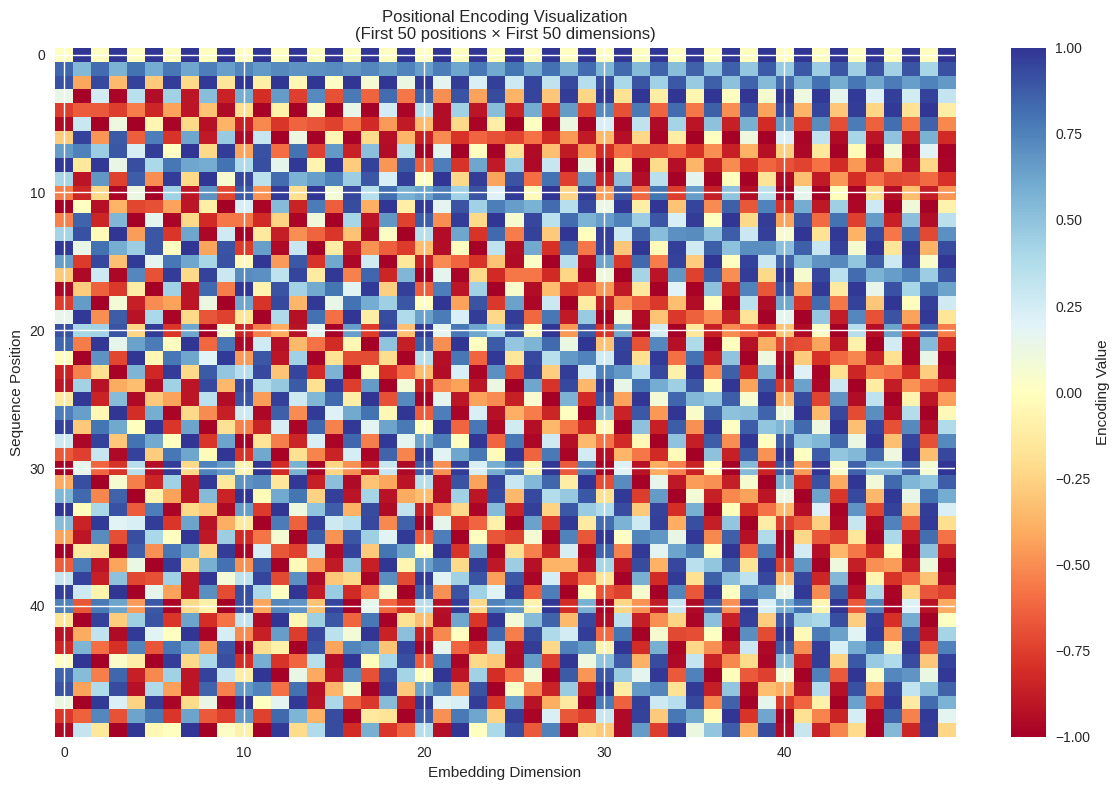

Notice the sinusoidal patterns! Each position has a unique encoding.


In [4]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding using sinusoidal functions

    This adds positional information to the input embeddings so the model
    knows the order of tokens in the sequence.
    """

    def __init__(self, d_model: int, max_seq_length: int = 5000, dropout: float = 0.1):
        """
        Args:
            d_model: Model dimension (embedding size)
            max_seq_length: Maximum sequence length to support
            dropout: Dropout probability
        """
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(dropout)

        # Create a matrix to hold positional encodings
        pe = torch.zeros(max_seq_length, d_model)

        # Create position indices [0, 1, 2, ..., max_seq_length-1]
        position = torch.arange(0, max_seq_length).unsqueeze(1).float()

        # Create division term for the sinusoidal functions
        # This creates [10000^(0/d_model), 10000^(2/d_model), ..., 10000^((d_model-2)/d_model)]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(math.log(10000.0) / d_model))

        # Apply sinusoidal functions
        # Even indices get sine, odd indices get cosine
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply to even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply to odd indices

        # Add batch dimension and register as buffer (not a parameter)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add positional encoding to input embeddings

        Args:
            x: Input embeddings [batch_size, seq_len, d_model]

        Returns:
            x + positional encoding [batch_size, seq_len, d_model]
        """
        # Add positional encoding (only up to sequence length)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Test positional encoding
print("Testing Positional Encoding:")
d_model, max_seq_len = 512, 100
pos_encoding = PositionalEncoding(d_model, max_seq_len)

# Create sample embeddings
seq_len, batch_size = 20, 2
sample_embeddings = torch.randn(batch_size, seq_len, d_model)

# Apply positional encoding
encoded = pos_encoding(sample_embeddings)
print(f"Input embeddings shape: {sample_embeddings.shape}")
print(f"With positional encoding shape: {encoded.shape}")
print("✓ Positional Encoding working correctly!")

# Visualize positional encoding patterns
plt.figure(figsize=(12, 8))
pe_matrix = pos_encoding.pe[0, :50, :50].numpy()  # First 50 positions, first 50 dimensions

plt.imshow(pe_matrix, cmap='RdYlBu', aspect='auto')
plt.title('Positional Encoding Visualization\n(First 50 positions × First 50 dimensions)')
plt.xlabel('Embedding Dimension')
plt.ylabel('Sequence Position')
plt.colorbar(label='Encoding Value')
plt.tight_layout()
plt.show()

print("Notice the sinusoidal patterns! Each position has a unique encoding.")


## 3. Feed-Forward Network

After self-attention, each position is processed through a position-wise feed-forward network. This is a simple 2-layer MLP that processes each position independently.

### Architecture:
1. **Linear layer**: d_model → d_ff (usually d_ff = 4 × d_model)  
2. **ReLU activation**: Introduces non-linearity
3. **Linear layer**: d_ff → d_model (back to original dimension)
4. **Dropout**: For regularization

### Purpose:
- Adds non-linearity to the model
- Allows complex transformations at each position
- Processes each position independently (no interaction between positions)


In [5]:
class FeedForwardNetwork(nn.Module):
    """
    Position-wise Feed-Forward Network

    A simple 2-layer MLP applied to each position separately.
    This adds non-linearity and allows complex transformations.
    """

    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        """
        Args:
            d_model: Model dimension (input/output size)
            d_ff: Feed-forward dimension (hidden layer size)
            dropout: Dropout probability
        """
        super(FeedForwardNetwork, self).__init__()

        # Two linear layers with ReLU activation in between
        self.linear1 = nn.Linear(d_model, d_ff)  # Expand dimension
        self.linear2 = nn.Linear(d_ff, d_model)  # Contract back to original
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through feed-forward network

        Args:
            x: Input tensor [batch_size, seq_len, d_model]

        Returns:
            Output tensor [batch_size, seq_len, d_model]
        """
        # Apply first linear layer, then ReLU, then dropout
        x = self.dropout(F.relu(self.linear1(x)))

        # Apply second linear layer
        x = self.linear2(x)

        return x

# Test feed-forward network
print("Testing Feed-Forward Network:")
d_model, d_ff = 512, 2048
ffn = FeedForwardNetwork(d_model, d_ff)

# Create sample input
batch_size, seq_len = 2, 10
sample_input = torch.randn(batch_size, seq_len, d_model)

# Forward pass
output = ffn(sample_input)
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")
print("✓ Feed-Forward Network working correctly!")


Testing Feed-Forward Network:
Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
✓ Feed-Forward Network working correctly!


## 4. Transformer Encoder Block

Now we combine all components into a complete transformer encoder block. This is the fundamental building unit that gets stacked to create deep transformer models.

### Architecture:
1. **Multi-Head Self-Attention** + Residual connection + Layer normalization
2. **Feed-Forward Network** + Residual connection + Layer normalization

### Key Features:
- **Residual connections**: Help with gradient flow in deep networks
- **Layer normalization**: Stabilizes training and improves convergence
- **Order matters**: Layer norm can be applied before (Pre-LN) or after (Post-LN) the sub-layers


In [6]:
class TransformerEncoderBlock(nn.Module):
    """
    A single Transformer Encoder Block

    Combines multi-head attention and feed-forward network with
    residual connections and layer normalization.
    """

    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        """
        Args:
            d_model: Model dimension
            num_heads: Number of attention heads
            d_ff: Feed-forward dimension
            dropout: Dropout probability
        """
        super(TransformerEncoderBlock, self).__init__()

        # Multi-head self-attention
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)

        # Feed-forward network
        self.feed_forward = FeedForwardNetwork(d_model, d_ff, dropout)

        # Layer normalization (we'll use Pre-LN architecture)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Dropout for residual connections
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Forward pass through transformer encoder block

        Args:
            x: Input tensor [batch_size, seq_len, d_model]
            mask: Optional attention mask

        Returns:
            Output tensor [batch_size, seq_len, d_model]
        """

        # Pre-Layer Norm architecture:
        # 1. Layer norm -> Self-attention -> Residual connection
        norm_x = self.norm1(x)
        attention_output, _ = self.self_attention(norm_x, norm_x, norm_x, mask)
        x = x + self.dropout(attention_output)  # Residual connection

        # 2. Layer norm -> Feed-forward -> Residual connection
        norm_x = self.norm2(x)
        ff_output = self.feed_forward(norm_x)
        x = x + self.dropout(ff_output)  # Residual connection

        return x

# Test transformer encoder block
print("Testing Transformer Encoder Block:")
d_model, num_heads, d_ff = 512, 8, 2048
encoder_block = TransformerEncoderBlock(d_model, num_heads, d_ff)

# Create sample input
batch_size, seq_len = 2, 10
sample_input = torch.randn(batch_size, seq_len, d_model)

# Forward pass
output = encoder_block(sample_input)
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")
print("✓ Transformer Encoder Block working correctly!")


Testing Transformer Encoder Block:
Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
✓ Transformer Encoder Block working correctly!


## 5. Complete Transformer Model

Now let's build a complete transformer model by stacking multiple encoder blocks. This creates a deep network capable of learning complex patterns and representations.

### Architecture:
1. **Token Embeddings**: Convert input tokens to dense vectors
2. **Positional Encoding**: Add position information
3. **N Encoder Blocks**: Stack of transformer layers
4. **Output Layer**: Final classification/generation layer

### Key Parameters:
- **vocab_size**: Size of vocabulary (number of unique tokens)
- **max_seq_length**: Maximum sequence length supported
- **num_layers**: Number of transformer blocks to stack
- **d_model**: Model dimension (embedding size)
- **num_heads**: Number of attention heads per block
- **d_ff**: Feed-forward dimension


In [7]:
class TransformerModel(nn.Module):
    """
    Complete Transformer Model

    A full transformer consisting of token embeddings, positional encoding,
    multiple encoder blocks, and an output layer.
    """

    def __init__(self, vocab_size: int, d_model: int, num_heads: int, num_layers: int,
                 d_ff: int, max_seq_length: int = 5000, dropout: float = 0.1):
        """
        Args:
            vocab_size: Size of vocabulary
            d_model: Model dimension (embedding size)
            num_heads: Number of attention heads
            num_layers: Number of transformer blocks
            d_ff: Feed-forward dimension
            max_seq_length: Maximum sequence length
            dropout: Dropout probability
        """
        super(TransformerModel, self).__init__()

        self.d_model = d_model

        # Token embeddings: convert token IDs to dense vectors
        self.token_embedding = nn.Embedding(vocab_size, d_model)

        # Positional encoding: add position information
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length, dropout)

        # Stack of transformer encoder blocks
        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Final layer normalization
        self.final_norm = nn.LayerNorm(d_model)

        # Output projection (for classification or language modeling)
        self.output_projection = nn.Linear(d_model, vocab_size)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights using Xavier/Glorot initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)

    def create_padding_mask(self, x: torch.Tensor, pad_token: int = 0) -> torch.Tensor:
        """
        Create mask to ignore padding tokens in attention

        Args:
            x: Input tensor [batch_size, seq_len]
            pad_token: Token ID used for padding

        Returns:
            Mask tensor [batch_size, 1, 1, seq_len]
        """
        mask = (x != pad_token).unsqueeze(1).unsqueeze(2)
        return mask

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Forward pass through the transformer

        Args:
            x: Input token IDs [batch_size, seq_len]
            mask: Optional attention mask

        Returns:
            Output logits [batch_size, seq_len, vocab_size]
        """

        # 1. Token embeddings (scale by sqrt(d_model) as in original paper)
        x = self.token_embedding(x) * math.sqrt(self.d_model)

        # 2. Add positional encoding
        x = self.positional_encoding(x)

        # 3. Pass through encoder blocks
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, mask)

        # 4. Final layer normalization
        x = self.final_norm(x)

        # 5. Output projection
        output = self.output_projection(x)

        return output

# Create a transformer model
print("Creating Complete Transformer Model:")
vocab_size = 10000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 1000

transformer = TransformerModel(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_seq_length=max_seq_length
)

# Count parameters
total_params = sum(p.numel() for p in transformer.parameters())
trainable_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1024**2:.1f} MB (fp32)")

# Test with sample input
batch_size, seq_len = 2, 50
sample_tokens = torch.randint(1, vocab_size, (batch_size, seq_len))  # Avoid token 0 (padding)

# Create padding mask (assume last 10 tokens are padding)
sample_tokens[:, -10:] = 0  # Set last 10 tokens to padding
mask = transformer.create_padding_mask(sample_tokens)

# Forward pass
with torch.no_grad():  # No gradients needed for testing
    output = transformer(sample_tokens, mask)

print(f"\nTesting forward pass:")
print(f"Input tokens shape: {sample_tokens.shape}")
print(f"Output logits shape: {output.shape}")
print("✓ Complete Transformer Model working correctly!")


Creating Complete Transformer Model:
Model created successfully!
Total parameters: 29,165,328
Trainable parameters: 29,165,328
Model size: ~111.3 MB (fp32)

Testing forward pass:
Input tokens shape: torch.Size([2, 50])
Output logits shape: torch.Size([2, 50, 10000])
✓ Complete Transformer Model working correctly!
